# House Data Analysis - Fortaleza/CE Brazil

## 1. Importing packages

In [122]:
import requests
import pandas as pd
from pandas_profiling import ProfileReport
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pycep_correios
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy import stats
from scipy.stats import norm
import warnings
import math
from PIL import Image
warnings.filterwarnings('ignore')

## 2. Loading the data from CSV File

### 2.1 Loading the data using pandas and creating a DataFrame

In [123]:
df_Properties = pd.read_csv('./Resources/data_cleanned.csv')


### 2.2 Looking how our dataset looks like 
 

In [124]:
df_Properties.head()

,Category,Type,Zipcode,City,Neighboor,Description,c_Elevador,c_Portaria,c_Piscina,c_Portao_eletronico,...,p_Armarios_na_cozinha,p_Academia,p_Area_de_servico,p_Mobiliado,p_Salao_de_festas,Price_Value,Area_value,Bedrooms_qty,Bathrooms_qty,Garage_qty
0,Apartamentos,Venda - apartamento padrão,60110370,Fortaleza,Meireles,Código do anúncio: LC0013\n\nConheça o Marbell...,1,1,1,0,...,0,1,0,1,0,690000,110,3,4,2
1,Apartamentos,Venda - apartamento padrão,60812260,Fortaleza,Edson Queiroz,Código do anúncio: AP0389\n\nEmpreendimento es...,1,0,1,0,...,0,0,0,0,0,499000,54,2,2,2
2,Apartamentos,Venda - apartamento padrão,60810220,Fortaleza,Engenheiro Luciano Cavalcante,Código do anúncio: AP0521\n\nExcelente apartam...,1,0,1,0,...,0,0,1,0,0,650000,82,3,3,2
3,Casas,Venda - casa em rua pública,60050040,Fortaleza,Centro,"Código do anúncio: fc35f6\n\nCasa, excelente p...",0,0,0,0,...,0,0,0,0,0,275000,145,3,2,0
4,Apartamentos,Venda - apartamento padrão,60824030,Fortaleza,Parque Iracema,Código do anúncio: DAVila_1-2318156\n\nCondomí...,0,0,1,0,...,0,0,0,0,0,450000,58,2,2,1


In [125]:
df_Properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226 entries, 0 to 8225
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Category               8226 non-null   object
 1   Type                   8226 non-null   object
 2   Zipcode                8226 non-null   int64 
 3   City                   8226 non-null   object
 4   Neighboor              8226 non-null   object
 5   Description            8226 non-null   object
 6   c_Elevador             8226 non-null   int64 
 7   c_Portaria             8226 non-null   int64 
 8   c_Piscina              8226 non-null   int64 
 9   c_Portao_eletronico    8226 non-null   int64 
 10  c_Condominio_fechado   8226 non-null   int64 
 11  c_Segurança_24h        8226 non-null   int64 
 12  c_Permitido_animais    8226 non-null   int64 
 13  c_Area_murada          8226 non-null   int64 
 14  c_Academia             8226 non-null   int64 
 15  c_Salao_de_festas    

## 3. Exploratory Data Analysis

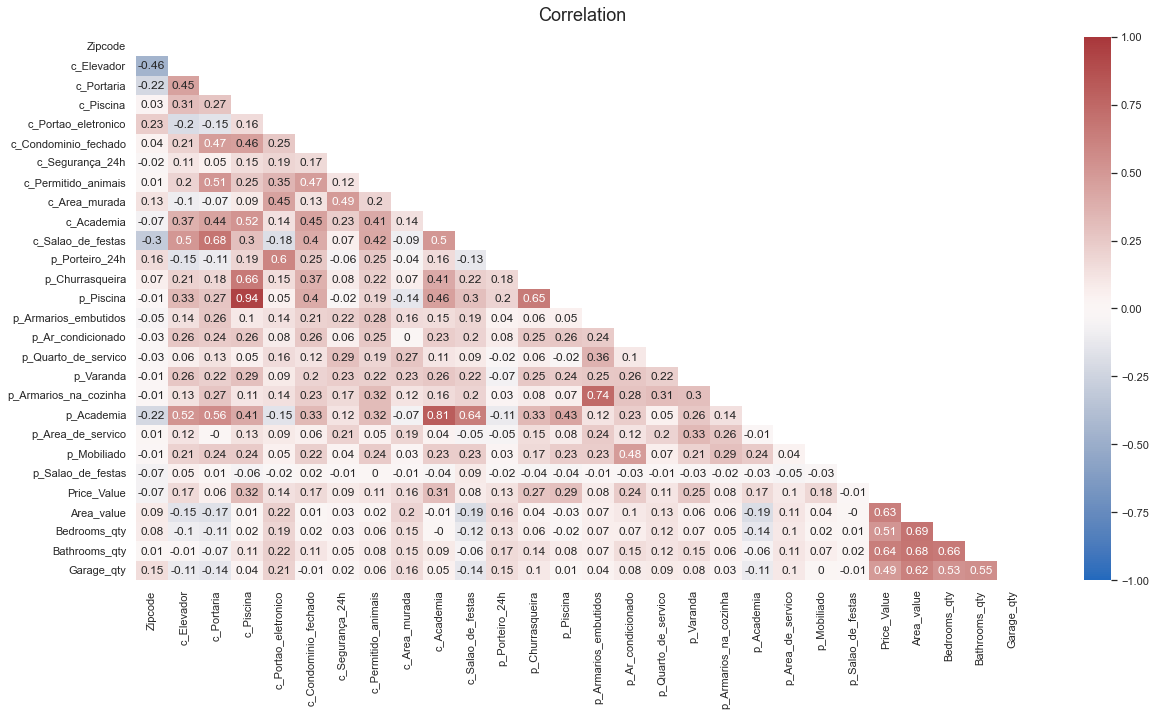

In [138]:
#Let's check the columns correlation
plt.figure(figsize=(20, 10))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
mask = np.triu(np.ones_like(df_Properties.corr().round(2), dtype=bool))
heatmap = sns.heatmap(df_Properties.corr().round(2), mask=mask, vmin=-1, vmax=1, annot=True, cmap="vlag")
heatmap.set_title('Correlation', fontdict={'fontsize':18}, pad=16)

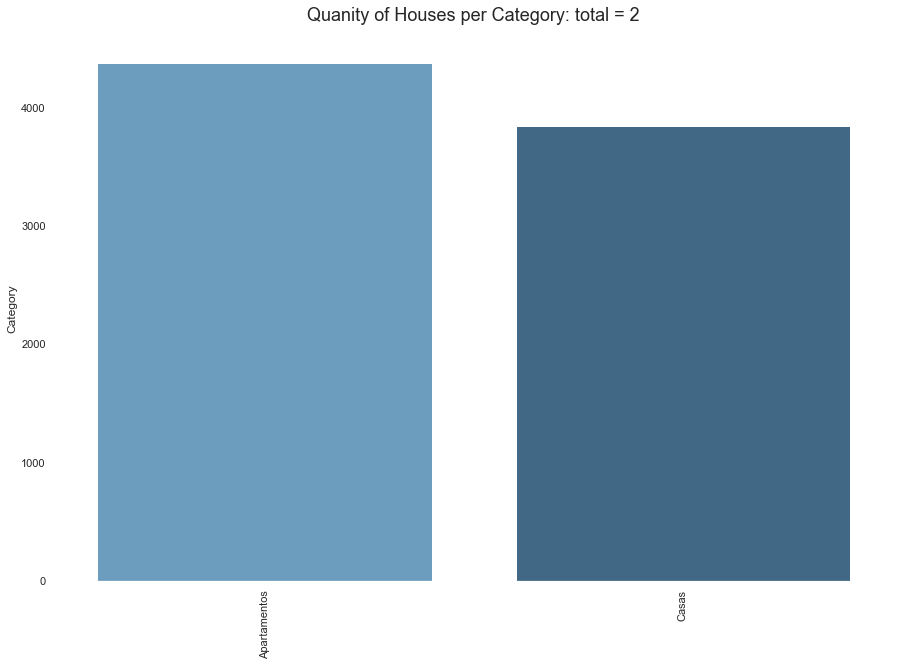

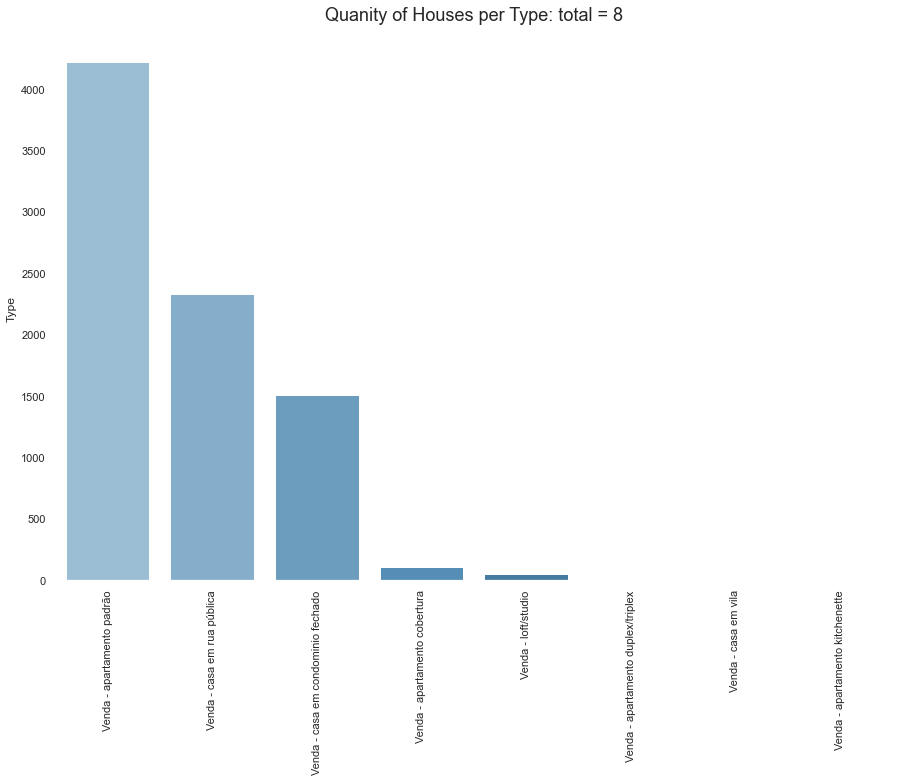

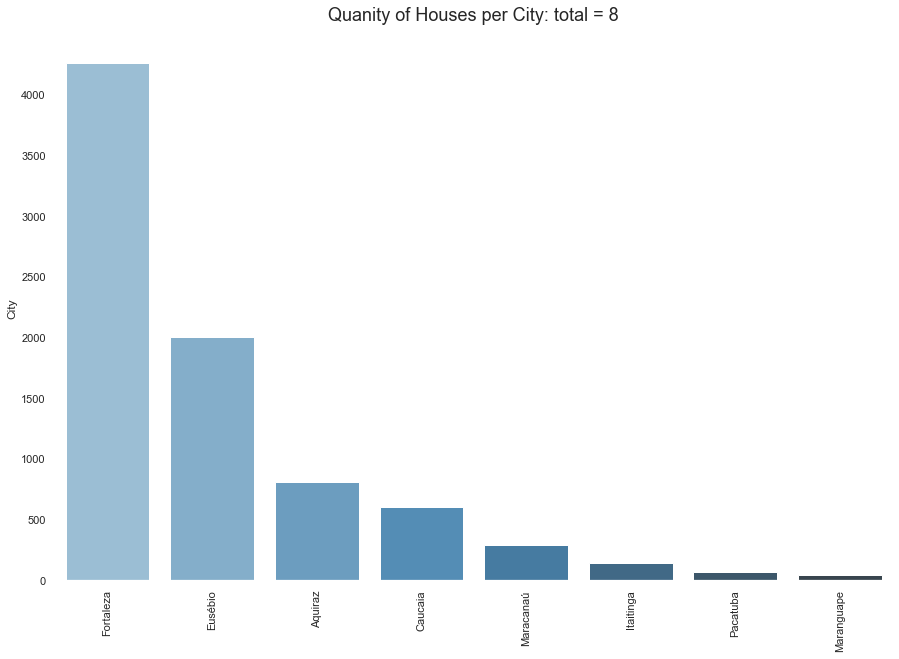

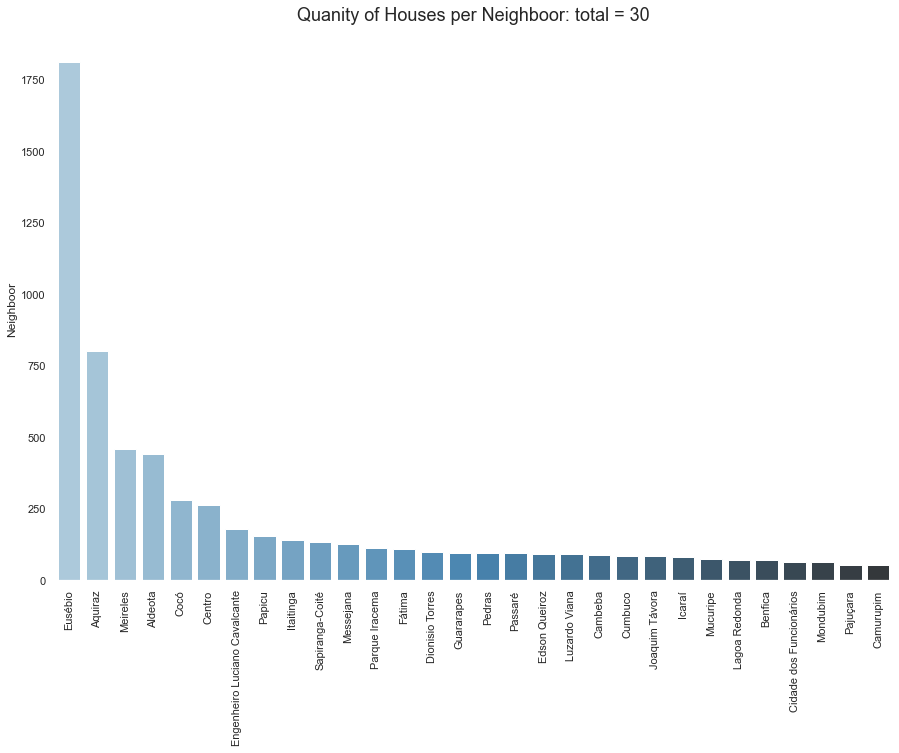

In [141]:
#Let's do some analysis
sns.set(rc={'figure.figsize':(15,10)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
for i in df_Properties[['Category','Type','City','Neighboor']].columns:
    cat_num = df_Properties[i].value_counts()[:30]
    chart = sns.barplot(x=cat_num.index, y=cat_num, palette='Blues_d')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
    chart.set_title("Quantity of Houses per %s: total = %d" % (i, len(cat_num)), fontdict={'fontsize':18}, pad=16)
    plt.show()